In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("chillwise_ac_usage_dataset.csv")
print(df.head())

   Hours_per_day  Temp_set  Room_size  Outside_temp  AC_type  Electricity_cost
0              8        27        109            27      1.0             515.0
1              5        28        257            33      1.5             806.0
2              6        22        252            30      2.0             902.0
3              8        22        202            33      1.0             757.0
4              4        22        183            37      2.0             820.0


In [3]:
from sklearn.metrics import r2_score

In [4]:
from xgboost import XGBRegressor

x_train = df.drop("Electricity_cost",axis=1)
y_train = df["Electricity_cost"]

xgb = XGBRegressor()

xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage 
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools import tool

In [ ]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192")

In [ ]:
from langchain.tools import tool

@tool
def mlModel(
    Hours_per_day: int,
    Temp_set: int,
    Room_size: int,
    Outside_temp: int,
    AC_type: float
) -> str:
    """
    Predict the electricity cost based on AC usage parameters.

    Args:
        Hours_per_day (int): Number of hours AC is used per day.
        Temp_set (int): Temperature set on the AC.
        Room_size (int): Size of the room in square feet.
        Outside_temp (int): Current outside temperature.
        AC_type (float): AC tonnage (e.g., 1.0, 1.5, 2.0).

    Returns:
        str: Predicted electricity cost in ₹.
    """
    df_test = pd.DataFrame({
        "Hours_per_day": [Hours_per_day],
        "Temp_set": [Temp_set],
        "Room_size": [Room_size],
        "Outside_temp": [Outside_temp],
        "AC_type": [AC_type]
    })
    prediction = xgb.predict(df_test)
    return f"The predicted electricity cost is ₹{prediction[0]:.2f}"


In [ ]:
tools = [mlModel]
tool_calling_llm = llm.bind_tools(tools)
def chat_llm(state: State):
    result = tool_calling_llm.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}  # <-- Append new response

def solution_llm(state: State):
    prediction_msg = state["messages"][-1]  # ML tool result
    user_msg = state["messages"][0].content  # original user message

    analysis_prompt = f"""
    Based on the user's AC usage:
    {user_msg}

    The predicted electricity cost is:
    {prediction_msg.content}

    Give a brief explanation and suggest one or two ways to optimize their AC usage and reduce cost.
    Like basically what temperature to keep in what amount of time to optimize the usage
    """

    result = llm.invoke([HumanMessage(content=analysis_prompt)])
    return {"messages": state["messages"] + [result]}



In [40]:
def decide_next(state):
    if "tool_call" in state:  # example condillm_with_tooltion
        return "tool"
    return "__end__"

In [48]:
graph_builder = StateGraph(State)
graph_builder.add_node("llm_with_tool", chat_llm)
graph_builder.add_node("tool", ToolNode(tools))
graph_builder.add_node("advice_agent",solution_llm)
graph_builder.add_edge(START, "llm_with_tool")



# tool always returns to llm_with_tool (never ends)
graph_builder.add_edge("llm_with_tool", "tool")
graph_builder.add_edge("tool","advice_agent")
graph_builder.add_edge("advice_agent",END)
# Remove this — redundant and might allow accidental END without condition
# graph_builder.add_edge("llm_with_tool", END)

graph = graph_builder.compile()


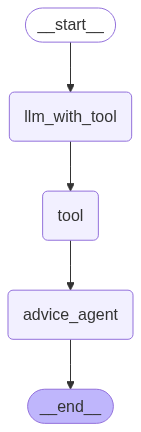

In [49]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
state = {
    "messages": [
        {
            "role": "user",
            "content": "My AC runs for 9 hours daily at 20 degrees. The room is 180 sq ft, outside temp is 38°C, and it’s a 2 ton AC. How much will I have to pay for electricity? Also, is this setup okay or am I wasting power?"
        }
    ]
}
response = graph.invoke(state)
print(response["messages"])

[HumanMessage(content='My AC runs for 9 hours daily at 20 degrees. The room is 180 sq ft, outside temp is 38°C, and it’s a 2 ton AC. How much will I have to pay for electricity? Also, is this setup okay or am I wasting power?', additional_kwargs={}, response_metadata={}, id='17864ad5-76f4-4463-a356-3629e848fd47'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n9p0mhsj2', 'function': {'arguments': '{"AC_type":2,"Hours_per_day":9,"Outside_temp":38,"Room_size":180,"Temp_set":20}', 'name': 'mlModel'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 1138, 'total_tokens': 1213, 'completion_time': 0.214285714, 'prompt_time': 0.044013539, 'queue_time': 0.291947141, 'total_time': 0.258299253}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2de508bbce', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d6cd9292-3763-42df-99d6-bd6ff7915bb4-0', tool_calls=[{'name': 'mlModel', 'args': {'AC_type': 2, 'Hours_pe

In [53]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

My AC runs for 9 hours daily at 20 degrees. The room is 180 sq ft, outside temp is 38°C, and it’s a 2 ton AC. How much will I have to pay for electricity? Also, is this setup okay or am I wasting power?
================================== Ai Message ==================================
Tool Calls:
  mlModel (n9p0mhsj2)
 Call ID: n9p0mhsj2
  Args:
    AC_type: 2
    Hours_per_day: 9
    Outside_temp: 38
    Room_size: 180
    Temp_set: 20
================================= Tool Message =================================
Name: mlModel

The predicted electricity cost is ₹1242.42
================================== Ai Message ==================================

Based on your AC usage, it's predicted that you'll have to pay approximately ₹1242.42 for electricity.

This setup may not be the most efficient, considering the outside temperature is quite high (38°C) and the AC is running for 9 hours daily. Here's why:

*